In [2]:
# Basic Cleaning and Analysis.
# Yiyang Liu Sept 12, 2024
# Data Cleaning and Simple Exploratory Script for the following dataset:
# https://www.kaggle.com/datasets/williamscott701/memotion-dataset-7k


import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
from PIL import Image
import os, sys
from wordcloud import WordCloud, STOPWORDS
warnings.filterwarnings('ignore')
%matplotlib inline


In [3]:
labelfile = ('memotion_dataset/labels.csv')
DB = pd.read_csv(labelfile).dropna()
DB = DB.reset_index(drop = True)

In [4]:
Sentiments_only = DB[['humour','sarcasm','offensive','motivational','overall_sentiment']]
map_humour = {'hilarious':3, 'very_funny':2, 'funny':1 , 'not_funny':0}
map_sarcasm = {'not_sarcastic':0, 'general':1, 'twisted_meaning':2, 'very_twisted':3}
map_offensive = {'not_offensive':0, 'slight':1, 'very_offensive':2, 'hateful_offensive':3}
map_motivational = {'not_motivational':0, 'motivational': 1}
map_sentiment = {'very_negative': -2, 'negative': -1, 'neutral': 0, 'positive':1, 'very_positive': 2}
# Note: more humorous/sarcastic/offensive = higher score.

Sentiments_only['humour'] = Sentiments_only['humour'].replace(map_humour)
Sentiments_only['sarcasm'] = Sentiments_only['sarcasm'].replace(map_sarcasm)
Sentiments_only['offensive'] = Sentiments_only['offensive'].replace(map_offensive)
Sentiments_only['motivational'] = Sentiments_only['motivational'].replace(map_motivational)
Sentiments_only['overall_sentiment'] = Sentiments_only['overall_sentiment'].replace(map_sentiment)

Sentiments_only

,humour,sarcasm,offensive,motivational,overall_sentiment
0,3,1,0,0,2
1,0,1,0,1,2
2,2,0,0,0,1
3,2,2,2,1,1
4,3,3,2,0,0
...,...,...,...,...,...
6825,2,2,2,1,0
6826,1,2,0,0,0
6827,1,1,1,0,1
6828,0,2,0,1,2


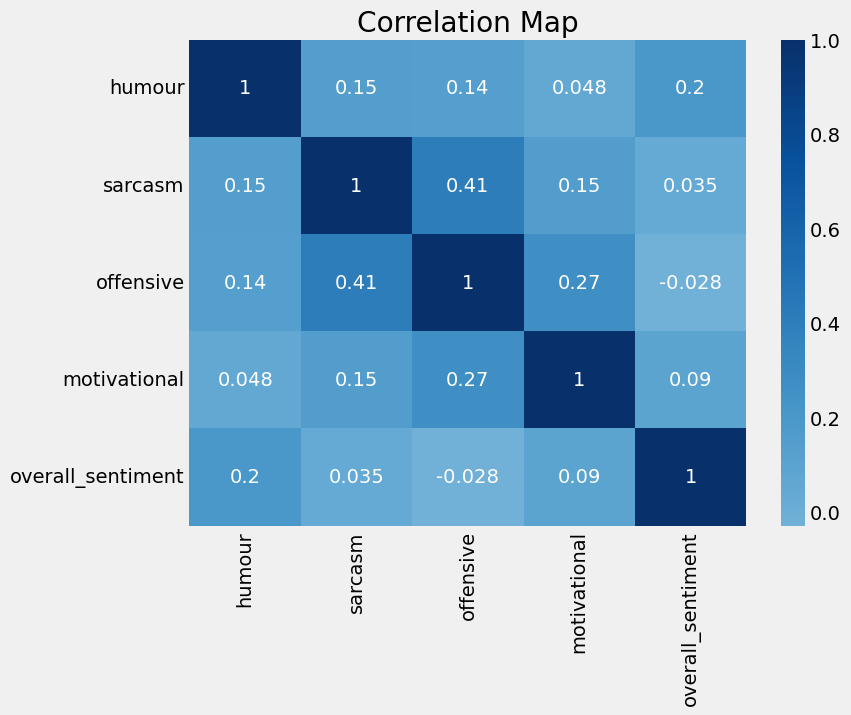

In [5]:
# Correlation between ratings. 
S_corr = Sentiments_only.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(S_corr, annot=True, cmap='Blues', center=0)
plt.title('Correlation Map')
plt.show()
# Interpretation? Sarcasm can be offensive. Very intuitive. 

In [9]:
# Now work with the Captions/Texts.
import re 
import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize


def text_to_set_np(row):
    # if we want to exclude the punctuation, but so far let's just use the easy way.
    row = re.sub(r'[^a-zA-Z0-9 ]+','',row)
    #row = re.sub(r'[^a-zA-Z0-9.,!?:; ]+','',row)
    row = row.lower().split()
    return row


def remove_watermark(row):
    patterns = [r".*com.*", r".*net.*", r".*co.*",r".*mobi.*", r".*modi.*", r"meme center", r"memecenter", r"memedroid",r"memetenler",r'avengermemes']
    combined_pattern = re.compile("|".join(patterns))
    for idx in range(len(row)-1,-1,-1):
        if combined_pattern.match(row[idx]):
            row.pop(idx)
    return row

def join_row(row):
    return ' '.join(map(str,row))
    


TXT_p= pd.DataFrame(DB['text_corrected']).applymap(text_to_set_np)
TXT_p = TXT_p.applymap(remove_watermark) #with punctuation
TXT_p = TXT_p.applymap(join_row)


#TXT_np= pd.DataFrame(DB['text_corrected']).applymap(text_to_set_np)
#TXT_np = TXT_np.applymap(remove_watermark) #without punctuation

print(TXT_p)
# Notes 
# Several things to take care of: 
# 1) get rid of all the special characters. (done)
# 2) site names like memegenerator.com (done)
# 3) Tentatively: Use word2vec(CBOW)/CoVe/BERT




                                         text_corrected
0     look there my friend lightyear now all sohalik...
1     the best of 10 yearchallenge in less the 4 yea...
2     sam thorne strippin follow follow saw everyone...
3                   10 year challenge sweet dee edition
4     10 year challenge with no filter 47 hilarious ...
...                                                 ...
6825  tuesday is mardi gras wednesday is valentines ...
6826  must watch movies of 2017 iti chennai memes ma...
6827  less more talking planning soda junk food worr...
6828  when i have time is a fantasy no one has time ...
6829  the starting point for every good idea is what...

[6830 rows x 1 columns]


In [10]:

TXT_word = TXT_p.applymap(word_tokenize)
print(TXT_word)
TXT_sent = TXT_p.applymap(sent_tokenize)

TXT_p.to_csv('TEXT_sentences.csv')
Sentiments_only.to_csv('Sentiments.csv')

                                         text_corrected
0     [look, there, my, friend, lightyear, now, all,...
1     [the, best, of, 10, yearchallenge, in, less, t...
2     [sam, thorne, strippin, follow, follow, saw, e...
3            [10, year, challenge, sweet, dee, edition]
4     [10, year, challenge, with, no, filter, 47, hi...
...                                                 ...
6825  [tuesday, is, mardi, gras, wednesday, is, vale...
6826  [must, watch, movies, of, 2017, iti, chennai, ...
6827  [less, more, talking, planning, soda, junk, fo...
6828  [when, i, have, time, is, a, fantasy, no, one,...
6829  [the, starting, point, for, every, good, idea,...

[6830 rows x 1 columns]


In [10]:


#create a filter for the entries
criterion0 = Sentiments_only['overall_sentiment']  >= -3
criterion1 = Sentiments_only['offensive']  >=0
criterion2 = Sentiments_only['sarcasm'] >=0
criterion3 = Sentiments_only['motivational'] > -1
criterion4 = Sentiments_only['humour'] >= 0

criteria = criterion0 & criterion1 & criterion2 & criterion3 & criterion4

idx = Sentiments_only.index[criteria].tolist()

all_words_str = ''
for i in idx:
    #print(TXT_np.loc[i].values)
    words = ' '.join(map(str,TXT_word.loc[i].values[0]))
    all_words_str += words + ' '




In [11]:
sw = set(STOPWORDS)
sw.update(['im','dont','memes','make','want','one','know','youre','u','go',
          'look','going','still','oh','let','get','got','will','cant',
          'thats', 'doesnt'])
sw.update(['people','man','day','time','take','see','now','never','someone','made','say','think','said','says'])
WC = WordCloud(width = 800, height = 800, stopwords=sw, background_color = 'white').generate(all_words_str)

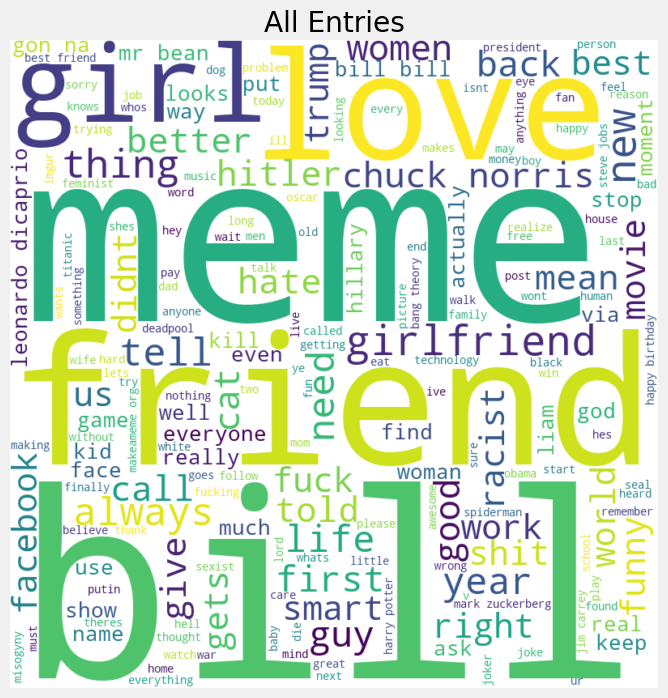

In [12]:
# Display the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(WC, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('All Entries')
plt.show()


#bill memes: This is bill. Bill is....
#Many memes about memes.
#Friend. Girlfriend. Girl. 
#trump hitler chuck norris who else?

In [ ]:
# Making all the images the same size.

from PIL import Image
import os, sys

path = ('type the path to the images here')

def resize_image():
for item in os.listdir(path):
    if os.path.isfile(item):
        im = Image.open(item)
        f, e = os.path.splitext(item)
        imResize = im.resize((200,200), Image.ANTIALIAS)
        imResize.save(f + ' resized.jpg', 'JPEG', quality=90)